
![D.lensalot logo](./../../res/dlensalot2.PNG)

# Interactive minimal working example - masked sky
In this notebook you perfrom QE and iterative lensing reconstruction for a single simulation, and for a masked sky.
The simulations are created upon runtime inclusive of isotropic white noise and without foregrounds, using a built-in CMB-simulations module.

We generate a simple mask leaving us with a sky fraction of about 17 percent.
Masked data for iterative lensing reconstruction results in a large, so called mean-field, and biases the lensing potential estimate.
To remove this bias, you will estimate the mean-field from a set of simulations.

We will use an isotropic noise model and ignore that the data is masked when we deproject the B-modes.
This is an approximation, and it were better to use the `build_OBD` job to create a better noise model.
However, this is out of scope for this tutorial.

At the end of this tutorial, you will plot the mean-field subtracted lensing potential estimate and obtain delensed power spectra to calculate the residual lensing amplitude.

The configuration file is [here](https://github.com/NextGenCMB/D.lensalot/blob/sv3.1/lenscarf/ana/config/examples/mwe/conf_mwe_fullsky.py), and you can freely change the parameters to your liking. In this configuration file, there are a few objects:

 * `DLENSALOT_Analysis` collects all configurations for the analysis of the data/simulations
 * `DLENSALOT_Data` configures the data which is used. In this minimal working example, we generate the simulation data on the fly and therefore need to choose the simulation module and a few parameters for this
 * `DLENSALOT_Noisemodel` configures the noise model with which the Wiener-filtering is done. 
 * `DLENSALOT_Qerec` and `DLENSALOT_Itrec` are lensing reconstruction specific settings.


In [1]:
import os
from os.path import join as opj
import numpy as np
import healpy as hp

import matplotlib.pyplot as plt

import lenscarf
from lenscarf.run import run

from lenscarf.lerepi.visalot import plot_helper as ph

cond4mpi does not exists
could not setup healpix hack. reverting to standard healpy
MSC: using scarf with 2 OMP threads


# Create mask
Any mask will do as long as the remaining sky fraction is large enough to calculate an unbinned power spectrum of the residual maps later

fsky: 0.167
INFO:: 02-04 02:14:: lenscarf.lerepi.core.handler.log - load_configfile() Started: /global/u2/s/sebibel/git/lenscarf/lenscarf/ana/config/examples/mwe/conf_mwe_maskedsky.py
INFO:: 02-04 02:14:: lenscarf.lerepi.core.handler.log - load_configfile() Finished
INFO:: 02-04 02:14:: lenscarf.lerepi.core.handler.log - store() Started
INFO:: 02-04 02:14:: lenscarf.lerepi.core.handler.log - load_configfile() Started: /global/cscratch1/sd/sebibel/dlensalot/lenscarf/generic/sims_cmb_len_lminB30_my_first_dlensalot_analysis_maskedsky/conf_mwe_maskedsky.py
INFO:: 02-04 02:14:: lenscarf.lerepi.core.handler.log - load_configfile() Finished
INFO:: 02-04 02:14:: root.store - config file look the same. Resuming where I left off last time.
INFO:: 02-04 02:14:: root.store - Matching config file found. Resuming where I left off.
INFO:: 02-04 02:14:: lenscarf.lerepi.core.handler.log - store() Finished
INFO:: 02-04 02:14:: lenscarf.lerepi.core.handler.log - collect_jobs() Started
INFO:: 02-04 02:14:

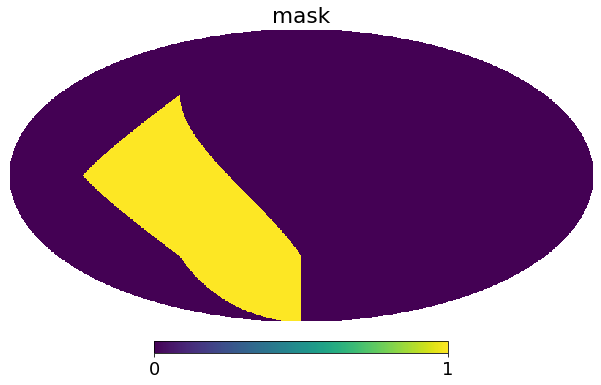

In [5]:
m = np.zeros(hp.nside2npix(1))
m[5] = 1
m[8] = 1
m = hp.ud_grade(m, nside_out=2048)
hp.mollview(m, nest=False, title='mask')
print('fsky: {:.3f}'.format(np.mean(m)))

fn = opj(os.path.dirname(os.path.abspath(lenscarf.__file__)),'ana/config/examples/mwe/conf_mwe_maskedsky.py')
ana_mwe = run(config=fn, job_id='QE_lensrec', verbose=True).job
mask_fn = opj(ana_mwe.TEMP,'mask.fits')
if not os.path.isfile(mask_fn):
    hp.write_map(mask_fn, m)

# QE lensing reconstruction
The following cell,
 
 * line 1: selects the [configuration file](https://github.com/NextGenCMB/D.lensalot/blob/sv3.1/lenscarf/ana/config/examples/mwe/conf_mwe_maskedsky.py) ,
 * line 2: initialises D.lensalot for a QE lensing reconstruction job (`job_id`),
 * line 3: perfroms lensing reconstruction and calculates both, the lensing potential, and the B-lensing template.


When run for the first time, `.run()` generates CMB simulations and stores them as defined in the `DLENSALOT_data.class_parameters.lib_dir` parameter (check out the configuration file). If this path is not convenient, please choose one that works for you.

In [11]:
fn = opj(os.path.dirname(os.path.abspath(lenscarf.__file__)),'ana/config/examples/mwe/conf_mwe_maskedsky.py')
ana_mwe = run(config=fn, job_id='QE_lensrec', verbose=True).job
# ana_mwe.run()

INFO:: 02-04 02:41:: lenscarf.lerepi.core.handler.log - load_configfile() Started: /global/u2/s/sebibel/git/lenscarf/lenscarf/ana/config/examples/mwe/conf_mwe_maskedsky.py
INFO:: 02-04 02:41:: lenscarf.lerepi.core.handler.log - load_configfile() Finished
INFO:: 02-04 02:41:: lenscarf.lerepi.core.handler.log - store() Started
INFO:: 02-04 02:41:: lenscarf.lerepi.core.handler.log - load_configfile() Started: /global/cscratch1/sd/sebibel/dlensalot/lenscarf/generic/sims_cmb_len_lminB30_my_first_dlensalot_analysis_maskedsky/conf_mwe_maskedsky.py
INFO:: 02-04 02:41:: lenscarf.lerepi.core.handler.log - load_configfile() Finished
INFO:: 02-04 02:41:: root.store - config file look the same. Resuming where I left off last time.
INFO:: 02-04 02:41:: root.store - Matching config file found. Resuming where I left off.
INFO:: 02-04 02:41:: lenscarf.lerepi.core.handler.log - store() Finished
INFO:: 02-04 02:41:: lenscarf.lerepi.core.handler.log - collect_jobs() Started
INFO:: 02-04 02:41:: lenscarf.l

# iterative lensing reconstruction

The following cell repeats above, but for the iterative case.
For the iterations, we use a fast Wiener-filtering, allowing us to get fast iterative results in an idealized setting.

(We could have skipped above cell entirely. As iterative lensing reconstruction depends on a QE starting point, Dlensalot would have known to run `QE_lensrec` first.)

In [ ]:
fn = opj(os.path.dirname(os.path.abspath(lenscarf.__file__)),'ana/config/examples/mwe/conf_mwe_maskedsky.py')
ana_mwe = run(config=fn, job_id='MAP_lensrec', verbose=True).job
ana_mwe.run()

INFO:: 02-04 02:48:: lenscarf.lerepi.core.handler.log - load_configfile() Started: /global/u2/s/sebibel/git/lenscarf/lenscarf/ana/config/examples/mwe/conf_mwe_maskedsky.py
INFO:: 02-04 02:48:: lenscarf.lerepi.core.handler.log - load_configfile() Finished
INFO:: 02-04 02:48:: lenscarf.lerepi.core.handler.log - store() Started
INFO:: 02-04 02:48:: lenscarf.lerepi.core.handler.log - load_configfile() Started: /global/cscratch1/sd/sebibel/dlensalot/lenscarf/generic/sims_cmb_len_lminB30_my_first_dlensalot_analysis_maskedsky/conf_mwe_maskedsky.py
INFO:: 02-04 02:48:: lenscarf.lerepi.core.handler.log - load_configfile() Finished
INFO:: 02-04 02:48:: root.store - config file look the same. Resuming where I left off last time.
INFO:: 02-04 02:48:: root.store - Matching config file found. Resuming where I left off.
INFO:: 02-04 02:48:: lenscarf.lerepi.core.handler.log - store() Finished
INFO:: 02-04 02:48:: lenscarf.lerepi.core.handler.log - collect_jobs() Started
INFO:: 02-04 02:48:: lenscarf.l

# Check your results
## lensing potential and mean-field
After completion of above cells, we can look at the reconstructed lensing potential.
`get_plm_it(idx, its)` returns the spherical harmonics of the lensing potential estimate for simulation `idx` and iteration `its`

In [5]:
ll = np.arange(0,ana_mwe.qe_lm_max_qlm[0]+1,1)
scale_factor = (ll*(ll+1))**2/(2*np.pi)
mask = hp.read_map(ana_mwe.mask_fn)
mf = np.load('/global/cscratch1/sd/sebibel/dlensalot/lenscarf/generic/sims_cmb_len_lminB30_my_first_dlensalot_analysis_maskedsky/mf_Nmf010/mf010_it000.npy')

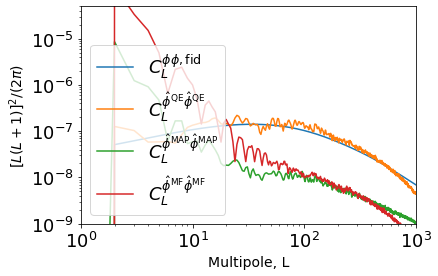

In [18]:
# plm_QE = ana_mwe.get_plm_it(0, [0])[0]
# plm_MAP = ana_mwe.get_plm_it(0, [1])[0]

plt.plot(scale_factor*ana_mwe.cpp, label=r'$C_L^{\phi\phi,{\rm fid}}$')
plt.plot(scale_factor*hp.alm2cl(plm_QE)/np.mean(mask), label=r'$C_L^{\hat{\phi}^{\rm QE}\hat{\phi}^{\rm QE}}$')
plt.plot(scale_factor*hp.alm2cl(plm_MAP), label=r'$C_L^{\hat{\phi}^{\rm MAP}\hat{\phi}^{\rm MAP}}$')

plt.plot(scale_factor*hp.alm2cl(mf)/np.mean(mask), label=r'$C_L^{\hat{\phi}^{\rm MF}\hat{\phi}^{\rm MF}}$')

plt.legend(fontsize=18)
plt.xlabel('Multipole, L', fontsize=14)
plt.ylabel(r'$\left[L(L+1)\right]^2/(2\pi)$', fontsize=14)
plt.xscale('log')
plt.xlim(1,1e3)
plt.ylim(1e-9,5e-5)
plt.yscale('log')

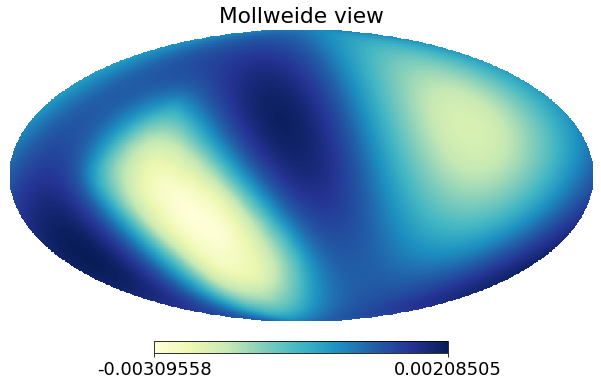

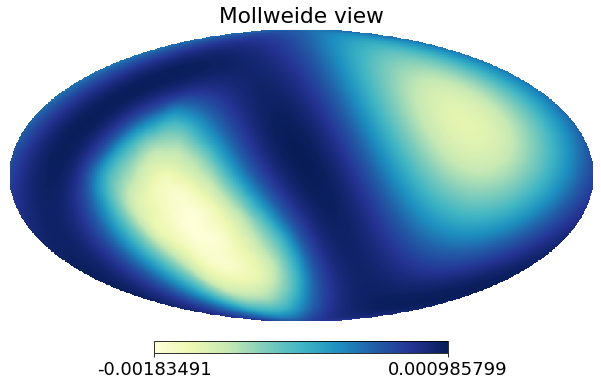

In [10]:
hp.mollview(hp.alm2map(plm_QE, nside=2048), cmap='YlGnBu')
hp.mollview(hp.alm2map(plm_MAP, nside=2048), cmap='YlGnBu')

# Delensed spectrum

In [5]:
input_blensing = hp.map2alm(hp.alm2map(ana_mwe._sims.get_sim_blm(0), nside=2048), lmax=1024)
blt_QE = ana_mwe.get_blt_it(0, 0, calc=False)
blt_MAP = ana_mwe.get_blt_it(0, 9, calc=False)

/global/u2/s/sebibel/git/lenscarf/lenscarf/core/handler.py:686: RuntimeWarning: invalid value encountered in true_divide
  np.save(fn, mf/self.Nmf)


In [6]:
blens_residual_QE = input_blensing - blt_QE
blens_residual_MAP = input_blensing - blt_MAP

Text(0, 0.5, '$C_\\ell [\\mu $$\\rm{K}^2$]')

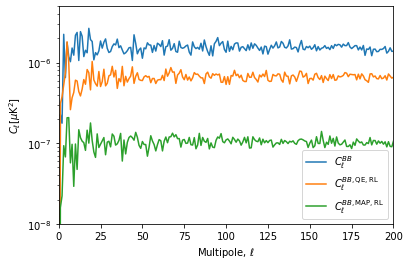

In [7]:
plt.plot(hp.alm2cl(input_blensing, lmax=200), label=r'$C_\ell^{BB}$')
plt.plot(hp.alm2cl(blens_residual_QE, lmax=200), label=r'$C_\ell^{BB,{\rm QE,RL}}$')
plt.plot(hp.alm2cl(blens_residual_MAP, lmax=200), label=r'$C_\ell^{BB,{\rm MAP,RL}}$')

plt.legend()
plt.yscale('log')
plt.xlim(0,200)
plt.ylim(1e-8,5e-6)
plt.xlabel('Multipole, $\ell$')
plt.ylabel('$C_\ell [\mu $'+r'$\rm{K}^2$]')

# mean-field

In [ ]:
mf = np.load('/global/cscratch1/sd/sebibel/dlensalot/lenscarf/generic/sims_cmb_len_lminB30_my_first_dlensalot_analysis_maskedsky/mf_Nmf010/mf010_it000.npy')

In [ ]:
hp.mollview(hp.alm2map(mf,nside=2048)*np.where(mask==0,np.nan,1), cmap='YlGnBu', title='mean-field')